# Volatility is (mostly) path-dependent - Guyon, Lekeufack (2022)

This notebook replicates the code for the prediction of the realized volatility from the paper "Volatility is (mostly) path-dependent" by Guyon and Lekeufack (2022). 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from volatility.volatility import (
    perform_empirical_study,
    fit_model,
    linear_of_kernels,
    inv_target_transform
)
from volatility.utils import (
    data_between_dates, dataframe_of_returns, split_data, data_between_dates
)

In [2]:
from volatility.plot_functions import(
    plot_timeseries,
    plot_prediction_vs_true,
    plot_prediction_timeseries,
    plot_vol_against_feature,
    plot_3d
    )
from collections.abc import Iterable

For a given volatility index $v$ and a market index $S$, for a given `setting` which is a list of tuples `(n,j)` or `(n, (j_1,..., j_k))` , for each timestep $t$ (in days):
$$
r_t = \frac{S_t - S_{t-1}}{S_{t-1}}
$$
$$
R_{n,t} = \sum_{t_i \leq t} K_n(t-t_i)r_{t_i}^n
$$

Then the model estimates the volatility as
$$
v_t^p = \beta_0 + \sum_{n} \sum_{j\in\{j_1,\dots, j_k\}} \beta_{n,j} R_{n,t}^j
$$
Note: when there is only one $j$ associated to $n$, $\beta_{n,j}$ is simply noted $\beta_n$.


For example, the linear model we suggest is defined by `p=1`, `setting=[(1,1), (2,1/2)]`, resulting in
$$
v_t = \beta_0 + \beta_1 R_{1,t} + \beta_2 R_{2,t}^{1/2}
$$
The model (M3) is defined by `p=2`, `setting=[(1,(1,2))]`, resulting in
$$
v_t^2 = \beta_0 + \beta_{1,1} R_{1,t} + \beta_{1,2} R_{1,t}^2
$$

Note that there is one kernel per $n$. The kernels are either time-shifted power-laws or convex combinations of two exponentials.

### Customized version for Optiver challenge

In this section I rewrite the methods so that they can be used for the inference as in the classical ML tasks. Moreover, the foresight bias introduces in the original implementation is removed.

In [ ]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

max_delta = 1000
p = 1
setting = [(1, 1), (2, 1/2)] # Our linear model

In [ ]:
# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [ ]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [ ]:
spx = spx_data['Close']
vix = vix_data['Close']/100

In [ ]:
# TODO: Test single version

# Create a dataframe of features
df = dataframe_of_returns(index=spx, vol=vix, max_delta=max_delta)

# Create train and test sets
train_data, test_data = split_data(
        df,
        train_start_date=train_start_date,
        test_start_date=test_start_date,
        test_end_date=test_end_date,
)
train_data = train_data.dropna()
test_data = test_data.dropna()
cols = [f"r_(t-{lag})" for lag in range(max_delta)]
X_train = train_data.loc[:, cols]
X_test = test_data.loc[:, cols]

index_train = train_data["index"]
vol_train = train_data["vol"]
index_test = test_data["index"]
vol_test = test_data["vol"]

# vol_train = data_between_dates(vix, train_start_date, test_start_date - pd.DateOffset(days=1))
# index_train = data_between_dates(spx, train_start_date, test_start_date - pd.DateOffset(days=1))

In [ ]:
df_train = data_between_dates(df, train_start_date, test_start_date - pd.DateOffset(days=1))
df_train

sol2 = fit_model(
    # vol=vol_train,
    # index=index_train,
    df=df_train,
    p=p,
    setting=setting,
    max_delta=max_delta
)

/home/juraj/Projects/volatility-path-dependent/volatility/utils.py:80: RuntimeWarning: invalid value encountered in power
  return (t + delta) ** (-alpha)
/home/juraj/Projects/volatility-path-dependent/volatility/utils.py:80: RuntimeWarning: invalid value encountered in power
  return (t + delta) ** (-alpha)


In [ ]:
sol2 = {
        key: sol2[key]
        for key in [
            "train_r2",
            "train_rmse",
            "features",
            "opt_params",
            "opt_params_original",
            "train_pred",
        ]
    }
sol2["opt_params"]

{'beta_0': 0.05729455476967705,
 'beta_1': -0.09462027431328149,
 'beta_2': 0.8183669914873963,
 'alpha_1': 1.0562015431119018,
 'alpha_2': 1.597177536398283,
 'delta_1': 0.020111644101859522,
 'delta_2': 0.051624749754352446}

In [ ]:
# scores
print({key: sol2[key] for key in ['train_r2', 'train_rmse']})

{'train_r2': 0.9461198466634522, 'train_rmse': 0.01999957121809064}


In [ ]:
# Compare the real and predicted values
pd.DataFrame(
    {"true": vol_train, "pred": sol2["train_pred"]},
)

,true,pred
2000-01-03,0.2421,0.159253
2000-01-04,0.2701,0.242791
2000-01-05,0.2641,0.228657
2000-01-06,0.2573,0.218505
2000-01-07,0.2172,0.202416
...,...,...
2018-12-24,0.3607,0.329839
2018-12-26,0.3041,0.309993
2018-12-27,0.2996,0.292473
2018-12-28,0.2834,0.285395


In [ ]:
# Split the data into train and test
# vol_test = data_between_dates(vix, test_start_date, test_end_date)
# index_test = data_between_dates(spx, test_start_date, test_end_date)

In [ ]:
# TODO: Compute 
# df = dataframe_of_returns(index=index_test, vol=vol_test, max_delta=max_delta)
# test_data = df
# test_data = test_data.dropna()
# cols = [f"r_(t-{lag})" for lag in range(max_delta)]
# X_test = test_data.loc[:, cols]
setting = [(i, p if isinstance(p, Iterable) else (p,)) for i, p in setting]

# Compute the predicted values
test_features, pred_test = linear_of_kernels(
    returns=X_test,
    setting=setting,
    parameters=sol2["opt_params_original"],
    return_features=True,
)

# Transform the predicted values
pred_test = np.clip(pred_test, 0, None)
vol_pred_test = inv_target_transform(pred_test, p)

In [ ]:
# Compare predictions and true values
pd.DataFrame(
    {"true": vol_test, "pred": vol_pred_test},
)

,true,pred
2019-01-02,0.2322,0.262431
2019-01-03,0.2545,0.295744
2019-01-04,0.2138,0.273289
2019-01-07,0.2140,0.261651
2019-01-08,0.2047,0.249313
...,...,...
2022-05-09,0.3475,0.351876
2022-05-10,0.3299,0.331935
2022-05-11,0.3256,0.340060
2022-05-12,0.3177,0.326243


### Original version

In [3]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('2000-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [4]:
# Load data on SPX and VIX
spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [5]:
vix_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-01-03 00:00:00-06:00,14.090000,14.710000,13.390000,14.250000,0,0.0,0.0
1995-01-04 00:00:00-06:00,13.870000,14.150000,13.530000,13.530000,0,0.0,0.0
1995-01-05 00:00:00-06:00,13.700000,14.190000,13.370000,13.500000,0,0.0,0.0
1995-01-06 00:00:00-06:00,13.670000,13.760000,12.790000,13.130000,0,0.0,0.0
1995-01-09 00:00:00-06:00,13.530000,14.080000,13.210000,13.330000,0,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-09 00:00:00-05:00,31.900000,35.480000,31.900000,34.750000,0,0.0,0.0
2022-05-10 00:00:00-05:00,33.660000,34.840000,32.240002,32.990002,0,0.0,0.0
2022-05-11 00:00:00-05:00,32.869999,34.389999,30.690001,32.560001,0,0.0,0.0


In [6]:
spx_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-01-03 00:00:00-05:00,459.209991,459.269989,457.200012,459.109985,262450000,0.0,0.0
1995-01-04 00:00:00-05:00,459.130005,460.720001,457.559998,460.709991,319510000,0.0,0.0
1995-01-05 00:00:00-05:00,460.730011,461.299988,459.750000,460.339996,309050000,0.0,0.0
1995-01-06 00:00:00-05:00,460.380005,462.489990,459.470001,460.679993,308070000,0.0,0.0
1995-01-09 00:00:00-05:00,460.670013,461.769989,459.739990,460.829987,278790000,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-09 00:00:00-04:00,4081.270020,4081.270020,3975.479980,3991.239990,5954520000,0.0,0.0
2022-05-10 00:00:00-04:00,4035.179932,4068.820068,3958.169922,4001.050049,5885820000,0.0,0.0
2022-05-11 00:00:00-04:00,3990.080078,4049.090088,3928.820068,3935.179932,5816140000,0.0,0.0


In [7]:
spx_data.index = pd.to_datetime(spx_data.index.date)
vix_data.index = pd.to_datetime(vix_data.index.date)

In [8]:
spx = spx_data['Close']
vix = vix_data['Close']/100

In [9]:
spx

1995-01-03     459.109985
1995-01-04     460.709991
1995-01-05     460.339996
1995-01-06     460.679993
1995-01-09     460.829987
                 ...     
2022-05-09    3991.239990
2022-05-10    4001.050049
2022-05-11    3935.179932
2022-05-12    3930.080078
2022-05-13    4023.889893
Name: Close, Length: 6891, dtype: float64

In [10]:
vix

1995-01-03    0.1425
1995-01-04    0.1353
1995-01-05    0.1350
1995-01-06    0.1313
1995-01-09    0.1333
               ...  
2022-05-09    0.3475
2022-05-10    0.3299
2022-05-11    0.3256
2022-05-12    0.3177
2022-05-13    0.2887
Name: Close, Length: 6891, dtype: float64

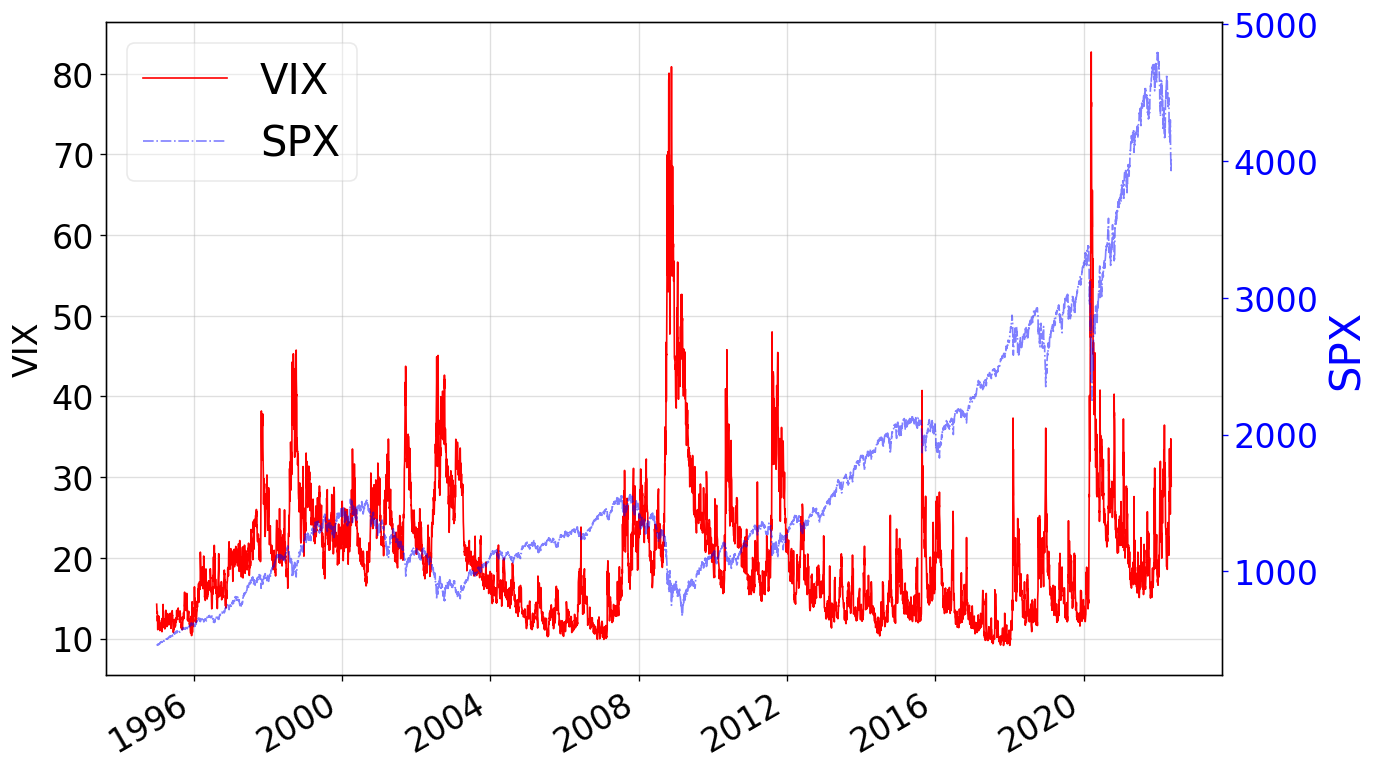

In [11]:
# Plot data
fig = plot_timeseries(100*vix, label='VIX', secondary=spx, secondary_label='SPX', 
                      add_hline=False, color_secondary='b', display_score=False)

In [12]:
max_delta = 1000  # Number of past returns used in the computation of R_{n,t} in business days
tspl = True # if True, use time-shifted power-law kernels. Otherwise, use a convex combination of two exponential

In [13]:
# Next cell runs in about 1-3 minutes if tspl=True, and up to 10 minutes if tspl=False.
p = 1
setting = [(1, 1), (2, 1/2)] # Our linear model
# setting = [(1, (1,2)), (2, 1/2)] # Our model with a parabolic term in R_1
sol = perform_empirical_study(
            vol=vix,
            index=spx,
            p=p,
            # tspl=tspl,
            setting=setting,
            train_start_date=train_start_date,
            test_start_date=test_start_date,
            test_end_date=test_end_date, 
            max_delta=max_delta
        )

/home/juraj/Projects/volatility-path-dependent/volatility/utils.py:80: RuntimeWarning: invalid value encountered in power
  return (t + delta) ** (-alpha)
/home/juraj/Projects/volatility-path-dependent/volatility/utils.py:80: RuntimeWarning: invalid value encountered in power
  return (t + delta) ** (-alpha)


In [14]:
sol.keys()

dict_keys(['train_r2', 'test_r2', 'train_rmse', 'test_rmse', 'features', 'opt_params', 'train_pred', 'test_pred'])

In [15]:
# Computed optimal parameters
sol['opt_params']

{'beta_0': 0.05729455476967705,
 'beta_1': -0.09462027431328149,
 'beta_2': 0.8183669914873963,
 'alpha_1': 1.0562015431119018,
 'alpha_2': 1.597177536398283,
 'delta_1': 0.020111644101859522,
 'delta_2': 0.051624749754352446}

In [16]:
# scores
print({key: sol[key] for key in ['train_r2', 'test_r2', 'train_rmse', 'test_rmse']})

{'train_r2': 0.9461198466634522, 'test_r2': 0.8553946646339643, 'train_rmse': 0.01999957121809064, 'test_rmse': 0.0351835043446566}


In [17]:
sol["train_pred"]

2000-01-03    0.159253
2000-01-04    0.242791
2000-01-05    0.228657
2000-01-06    0.218505
2000-01-07    0.202416
                ...   
2018-12-24    0.329839
2018-12-26    0.309993
2018-12-27    0.292473
2018-12-28    0.285395
2018-12-31    0.270078
Length: 4779, dtype: float64

In [18]:
sol["test_pred"]

2019-01-02    0.262431
2019-01-03    0.295744
2019-01-04    0.273289
2019-01-07    0.261651
2019-01-08    0.249313
                ...   
2022-05-09    0.351876
2022-05-10    0.331935
2022-05-11    0.340060
2022-05-12    0.326243
2022-05-13    0.300386
Length: 849, dtype: float64

In [19]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred'] * 100
pred_on_train = sol['train_pred'] * 100
target_on_test = data_between_dates(vix, start_date=test_start_date, end_date=test_end_date) * 100 
target_on_train = data_between_dates(vix, start_date=train_start_date, end_date=test_start_date) * 100
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

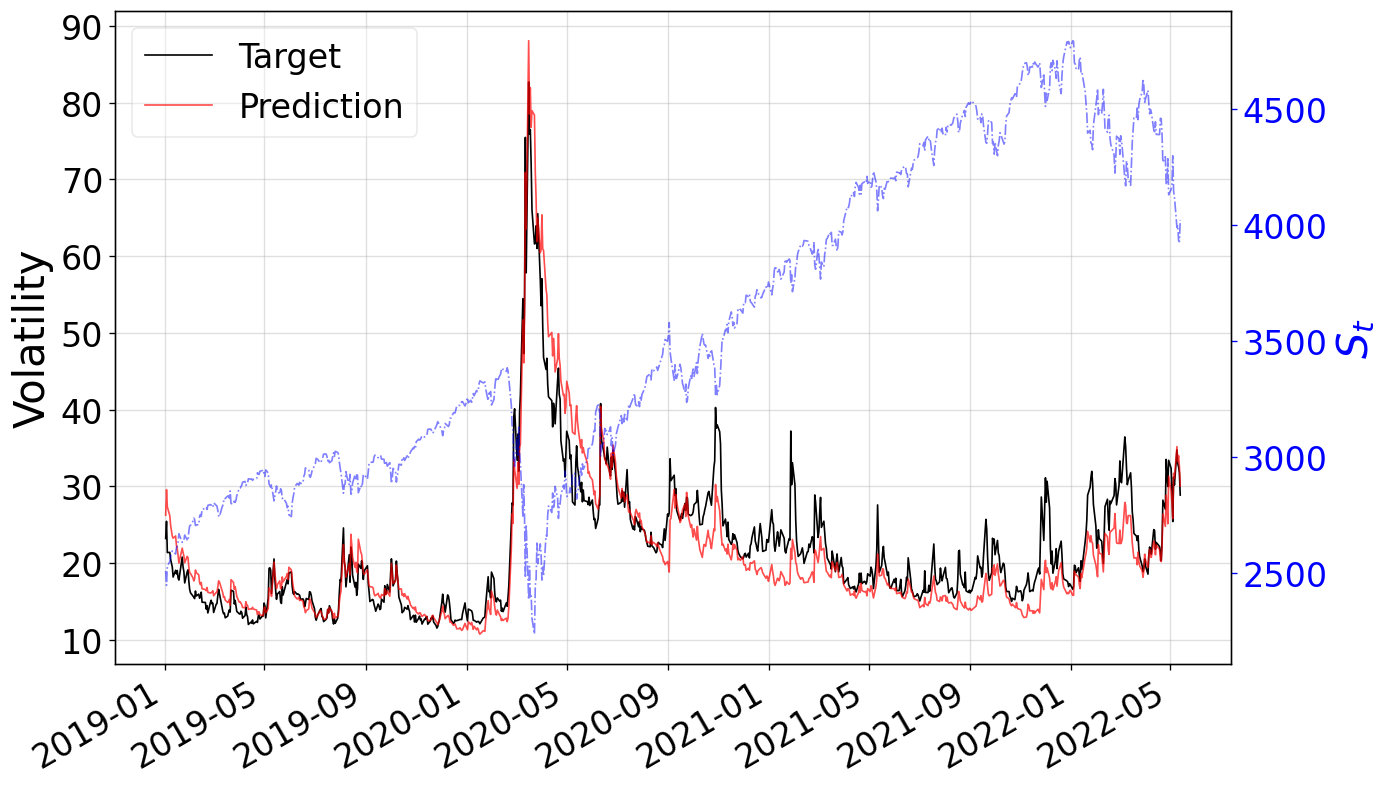

In [20]:
fig = plot_prediction_timeseries(y_target=target_on_test, y_pred=pred_on_test, index=index_on_test)

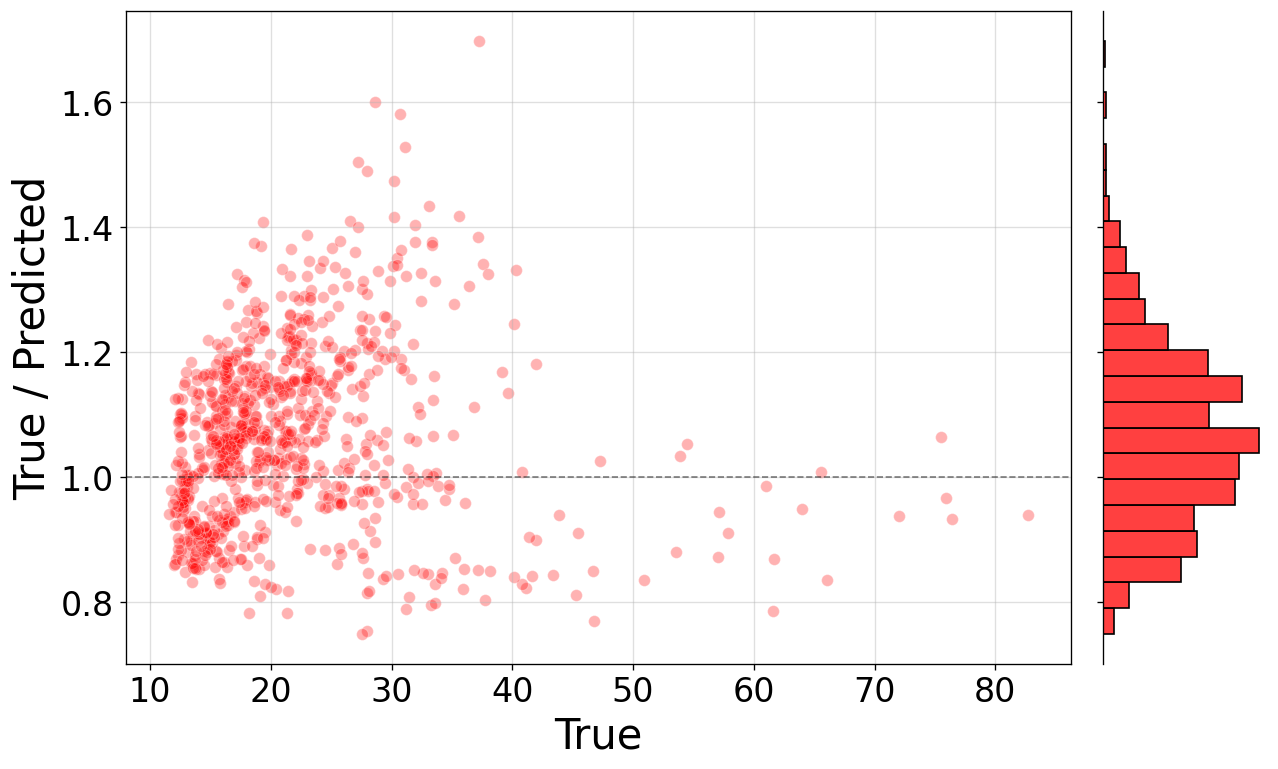

In [21]:
# Plot residuals on train set
fig = plot_prediction_vs_true(y_pred=pred_on_test, y_target=target_on_test, plot_residuals=True, ratio_residuals=True)

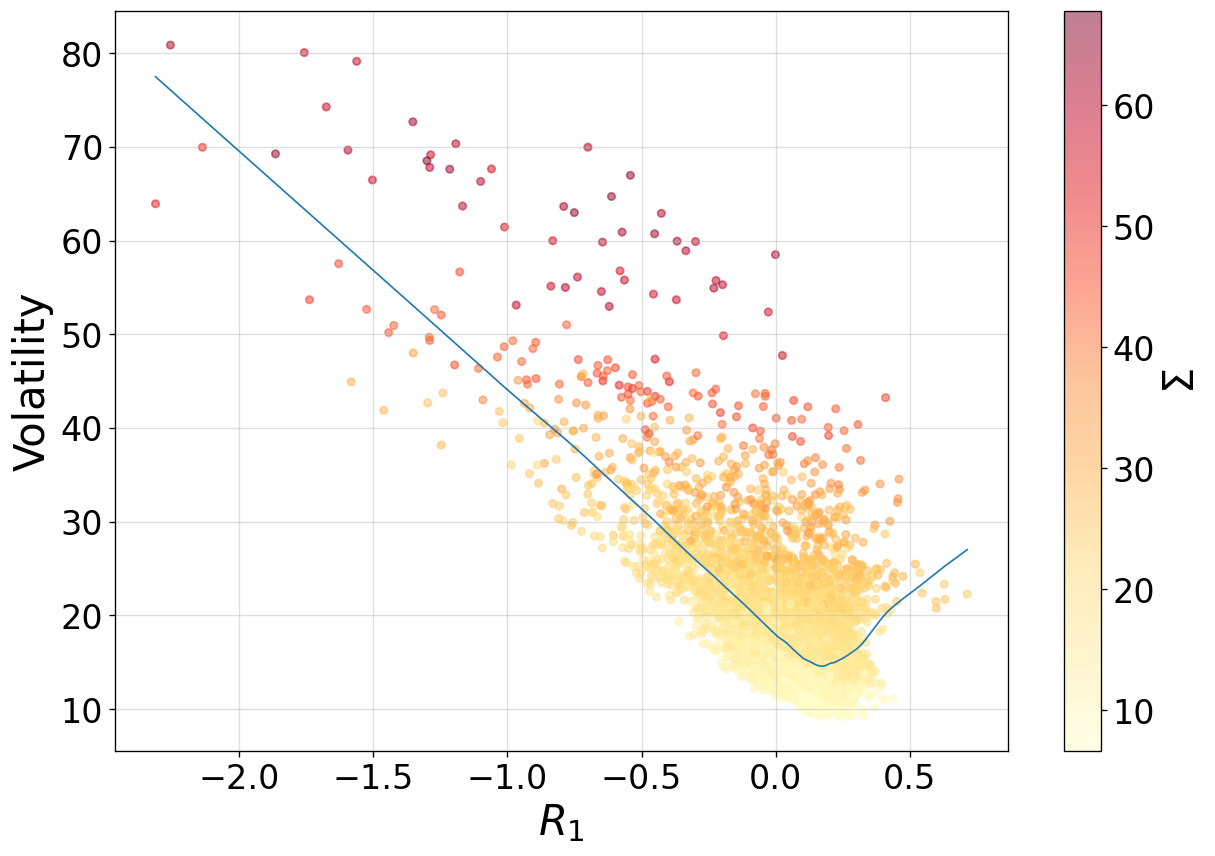

In [22]:
### Target vs Features
r_1_train = data_between_dates(sol['features']['R_1'], start_date=train_start_date, end_date=test_start_date)
sigma_train =  data_between_dates(sol['features']['R_2^0.5'], start_date=train_start_date, end_date=test_start_date) * 100
fig = plot_vol_against_feature(feature=r_1_train, target=target_on_train, color_variable=sigma_train, 
                               color_label='$\Sigma$', feature_name='$R_1$')

/home/juraj/Projects/volatility-path-dependent/volatility/plot_functions.py:440: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/home/juraj/Projects/volatility-path-dependent/volatility/plot_functions.py:443: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


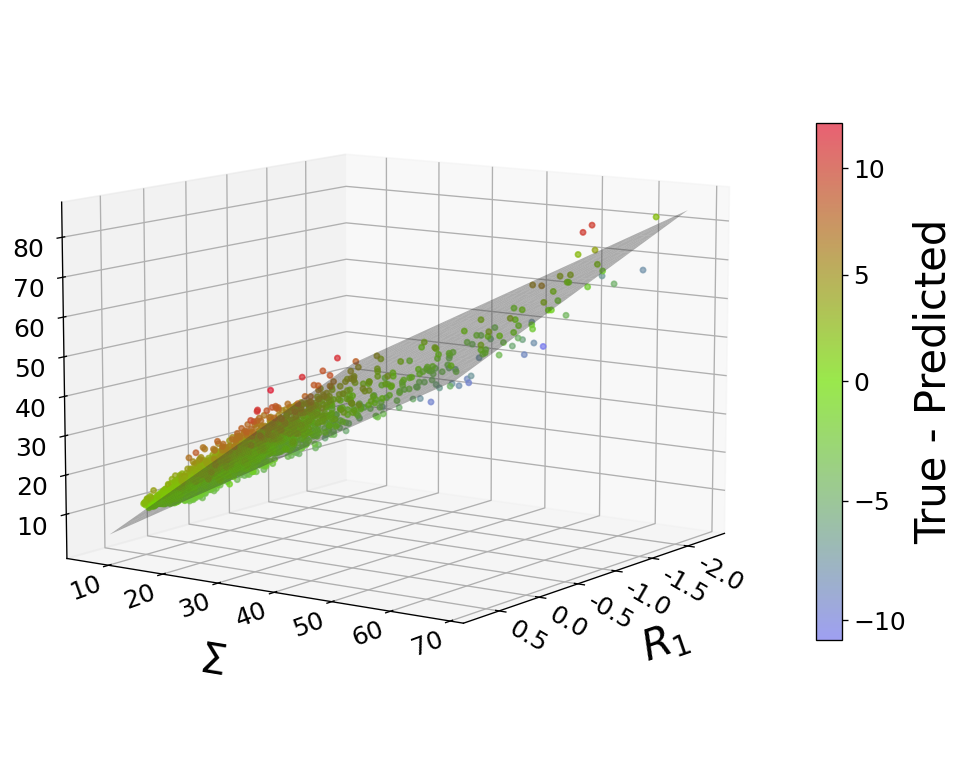

In [23]:
fig = plot_3d(r_1_train, sigma_train, target_on_train, xlabel='$R_1$', ylabel='$\Sigma$', zlabel='VIX') # figsize=bigfigsize)